## Training and testing of the GPT-2 model on the train dataset (Reddit book reviews)

In [1]:
from transformers import DataCollatorWithPadding
from transformers import AutoTokenizer
from datasets import load_dataset
import torch
from transformers import AutoModelForSequenceClassification
import numpy as np
import evaluate
from transformers import TrainingArguments, Trainer
from scipy.special import softmax
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
import time
 

In [2]:
torch.manual_seed(42)

In [3]:
train_dataset = load_dataset("csv", data_files="books_train.csv")["train"]
test_dataset = load_dataset("csv", data_files="books_test.csv")["train"]

In [4]:
device = torch.device('cuda')

In [5]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

In [6]:
def preprocess_function(examples):
    inputs = tokenizer(examples["body"], truncation=True, return_tensors="pt", padding=True).to(device)
    return inputs
 

In [7]:
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

In [8]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [9]:
model = AutoModelForSequenceClassification.from_pretrained("gpt2", num_labels=2).to(device)
model.config.pad_token_id = model.config.eos_token_id

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Identifying the metrics for training the model

In [10]:
def compute_metrics(eval_pred):
   load_precision = evaluate.load("precision")
   load_f1 = evaluate.load("f1")
  
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   precision = load_precision.compute(predictions=predictions, references=labels)
   f1 = load_f1.compute(predictions=predictions, references=labels)
   return {"precision": precision, "f1": f1}

In [11]:
repo_name = "finetuning-gpt2-Reddit-books"
 
training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=1e-4,
   per_device_train_batch_size=1,
   per_device_eval_batch_size=1,
   num_train_epochs=6,
   weight_decay=0.05,
   # save_strategy="steps",
   # push_to_hub=True,
   logging_steps=10,  # Print loss every 10 steps
   log_level="info",
   push_to_hub=False,
)
 
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)


/tmp/ipykernel_9308/2859897648.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [12]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `GPT2ForSequenceClassification.forward` and have been ignored: body. If body are not expected by `GPT2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 200
  Num Epochs = 6
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 1,200
  Number of trainable parameters = 124,441,344


Step,Training Loss
10,6.163800
20,2.931400
30,0.682700
40,1.644200
50,2.596700
60,1.930700
70,2.982000
80,1.522200
90,3.042500
100,2.654100


Saving model checkpoint to finetuning-gpt2-Reddit-books/checkpoint-500
Configuration saved in finetuning-gpt2-Reddit-books/checkpoint-500/config.json
Model weights saved in finetuning-gpt2-Reddit-books/checkpoint-500/model.safetensors
tokenizer config file saved in finetuning-gpt2-Reddit-books/checkpoint-500/tokenizer_config.json
Special tokens file saved in finetuning-gpt2-Reddit-books/checkpoint-500/special_tokens_map.json
Saving model checkpoint to finetuning-gpt2-Reddit-books/checkpoint-1000
Configuration saved in finetuning-gpt2-Reddit-books/checkpoint-1000/config.json
Model weights saved in finetuning-gpt2-Reddit-books/checkpoint-1000/model.safetensors
tokenizer config file saved in finetuning-gpt2-Reddit-books/checkpoint-1000/tokenizer_config.json
Special tokens file saved in finetuning-gpt2-Reddit-books/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to finetuning-gpt2-Reddit-books/checkpoint-1200
Configuration saved in finetuning-gpt2-Reddit-books/checkpoint-12

TrainOutput(global_step=1200, training_loss=0.9746725975254776, metrics={'train_runtime': 361.143, 'train_samples_per_second': 3.323, 'train_steps_per_second': 3.323, 'total_flos': 627112201420800.0, 'train_loss': 0.9746725975254776, 'epoch': 6.0})

In [13]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `GPT2ForSequenceClassification.forward` and have been ignored: body. If body are not expected by `GPT2ForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 100
  Batch size = 1


{'eval_loss': 2.147846221923828,
 'eval_precision': {'precision': 0.7790697674418605},
 'eval_f1': {'f1': 0.8481012658227848},
 'eval_runtime': 9.0795,
 'eval_samples_per_second': 11.014,
 'eval_steps_per_second': 11.014,
 'epoch': 6.0}

## Calculating accuracy

In [14]:
inputs = tokenizer(test_dataset['body'], truncation=True, return_tensors="pt", padding=True).to("cpu")
model_cpu = model.to("cpu")
with torch.no_grad():
    logits = model_cpu(**inputs).logits


predictions = np.argmax(logits, axis=-1)
labels = test_dataset["label"]
load_accuracy = evaluate.load("accuracy")
accuracy = load_accuracy.compute(predictions=predictions, references=labels)
print({"accuracy": accuracy})

{'accuracy': {'accuracy': 0.76}}


## Accuracy is 0.76, precision is 0.78, F1-score is 0.85

In [15]:
#logits of the inference on the testing data
Reddit_gpt_logits = logits.numpy()

## PR curve: calculating precision and recall


In [16]:
y_true = np.array(test_dataset["label"])
Reddit_gpt_precision = []
Reddit_gpt_recall = []
Reddit_gpt_probabilities = softmax(Reddit_gpt_logits, axis=1)
threshold = list(np.arange(0.0, 1, 0.001))
for t in threshold:
    y_scores = (Reddit_gpt_probabilities[:, 1] > t).astype(int)
    Reddit_gpt_precision.append(precision_score(y_true, y_scores, zero_division=1))
    Reddit_gpt_recall.append(recall_score(y_true, y_scores, zero_division=1))

Reddit_gpt_precision.append(1)
Reddit_gpt_recall.append(0)

## Baseline model which always returns the most frequent class

In [17]:
y_score_baseline = np.ones(y_true.shape)
baseline_precision = precision_score(y_true, y_score_baseline, zero_division=1)
baseline_recall = recall_score(y_true, y_score_baseline, zero_division=1)

## Plotting the PR curve

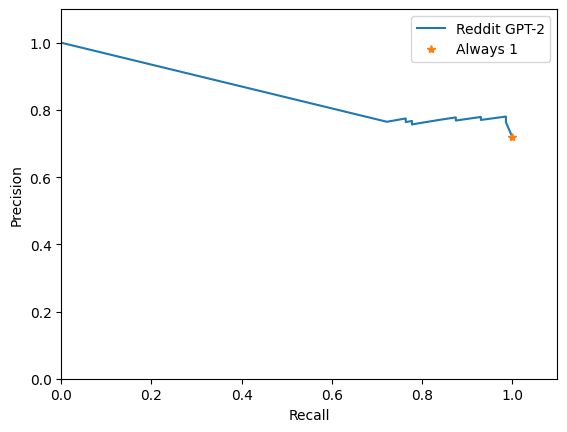

In [23]:
fig, ax = plt.subplots()
ax.plot(Reddit_gpt_recall, Reddit_gpt_precision, '-', label='Reddit GPT-2')
ax.plot([baseline_recall], [baseline_precision], '*', label='Always 1')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_xlim((0, 1.1))
ax.set_ylim((0, 1.1))
ax.legend()

In [19]:
np.savetxt("Reddit_gpt_logits.csv", Reddit_gpt_logits, delimiter = ",")

## Estimating inference time

In [21]:
time_start = time.perf_counter()
model_cpu = model.to("cpu")

for text in test_dataset["body"]:
        request = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to('cpu')
        outputs = model_cpu(**request)

time_end = time.perf_counter()
    
print(f'Took {(time_end - time_start):.3f} seconds')

Took 17.731 seconds
